In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import file_utils    
import utils
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import time
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def get_missed_predictions(tourney_comp_ratings, model_features, numeric_feature_to_scale,
                           prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [3]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

In [4]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [5]:
# Do not use 2018 data for training
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament.

In [7]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings =  utils.implement_top_conference_feature(game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor


In [8]:
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor
0,2003,64,2003-03-21 00:00:00.0000000,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,60,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,58,-1,2002,Lose,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,Pacific 12,Pacific 12,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,2.0,0.007,1.0,1.0,0.063,8.0,8.0,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,-39
1,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55,1,2002,Win,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,Southeastern,Southland,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,4.0,0.017,-1.0,-1.0,-0.002,6.0,7.0,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-162
2,2003,32,2003-03-23 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,68,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,62,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,5.0,-0.012,2.0,3.0,0.092,9.0,8.0,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-24
3,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-6.0,0.022,1.0,-1.0,-0.026,8.0,5.0,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,6
4,2003,4,2003-04-05 00:00:00.0000000,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,95,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,84,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.0,-0.029,3.0,-2.0,0.027,7.0,6.0,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-9


In [9]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_mor']

# Convert types to float to eliminate needless scaler warning 
for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)


In [10]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']
feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1.0,3.05,0.86,-8.0,12.0,8.0,2.0,12.0,5.0,-4.0,-39.0,2003,0,0
1,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13.0,20.19,14.63,-131.0,-91.0,-104.0,-133.0,-73.0,-128.0,-85.0,-162.0,2003,1,0
2,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8.0,4.28,-1.38,-34.0,-38.0,-36.0,-33.0,-36.0,-33.0,-39.0,-24.0,2003,0,0
3,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3.0,-1.93,4.63,23.0,31.0,13.0,12.0,17.0,27.0,21.0,6.0,2003,1,0
4,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2.0,-0.11,0.25,-7.0,-7.0,2.0,-6.0,-5.0,-8.0,2.0,-9.0,2003,0,0


In [11]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
X_train = X_train.copy()
X_test = X_test.copy()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 22)
(782,)
(196, 22)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,top_conf_t,top_conf_o
784,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3.0,-10.13,-6.65,97.0,106.0,98.0,94.0,88.0,80.0,103.0,102.0,0,1
125,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7.0,5.32,-3.24,-24.0,-33.0,-25.0,-25.0,-28.0,-24.0,-30.0,-19.0,0,1
236,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3.0,4.23,0.00,-11.0,-11.0,-15.0,-13.0,-14.0,-12.0,-18.0,-14.0,0,0
719,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0.0,-1.24,0.41,8.0,1.0,3.0,2.0,-4.0,-16.0,12.0,-7.0,0,0
808,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11.0,12.38,11.36,-64.0,-66.0,-58.0,-98.0,-79.0,-56.0,-78.0,-73.0,1,0


#### Scale the input data.
Note the input sets are scaled independently to prevent data snooping.

In [13]:
scaler=StandardScaler(copy=True, with_mean=True, with_std=True)

scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

#### LinearSVM Model

In [14]:
#svm = LinearSVC(C=1.0, dual=False)
svm = SVC(kernel='linear', probability=True)
result = svm.fit(X_train,y_train)


In [15]:
y_pred = svm.predict(X_test)

array([[69, 20],
       [16, 91]], dtype=int64)

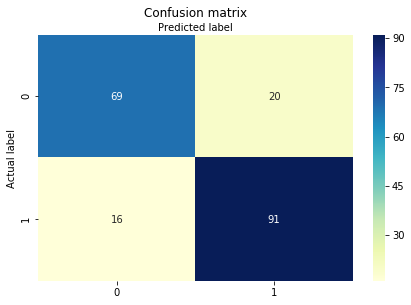

In [16]:
utils.display_confusion_matrix(y_test, y_pred)

In [17]:
prediction_probabilities = svm.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.8163265306122449
Precision: 0.8198198198198198
Recall: 0.8504672897196262
Log loss=  0.4585081121569682


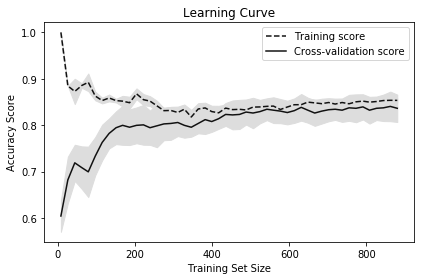

In [18]:
X_copy = X.copy()
X_copy[numeric_features] = scaler.transform(X_copy[numeric_features])
train_sizes, train_scores, test_scores = learning_curve(svm, 
                                                        X_copy, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Polynomial Kernel

In [19]:
svm_p = SVC(kernel="poly", degree=3, coef0=1, C=5, gamma="auto", probability=True)
result_p = svm_p.fit(X_train,y_train)

In [20]:
y_pred = svm_p.predict(X_test)

array([[61, 28],
       [18, 89]], dtype=int64)

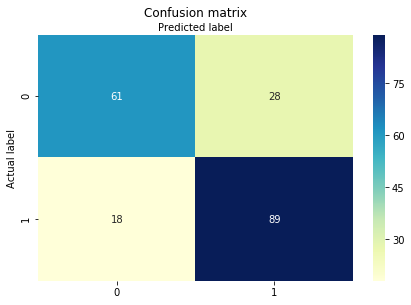

In [21]:
utils.display_confusion_matrix(y_test, y_pred)

In [22]:
prediction_probabilities = svm_p.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7653061224489796
Precision: 0.7606837606837606
Recall: 0.8317757009345794
Log loss=  0.5524947543280608


##### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

#### Grid Search

In [ ]:
param_grid = {
    "degree" : [2,3,5,8],
    "coef0": [0.1, 0.5, 1.0],
    "C" : [1,5,10]
}

grid_search = GridSearchCV(SVC(kernel='poly', gamma="auto"), param_grid=param_grid, cv=5)

start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


### Run Model Against 2018 Tournament

In [23]:
test_year = 2018

# scale the feature data corresponding to the 2018 tournament
feature_copy = feature_data[feature_data['season_t'] == test_year].copy()
feature_copy[numeric_features] = scaler.transform(feature_copy[numeric_features])
feature_copy.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
981,0.370585,-0.915614,0.413233,-1.509369,0.595567,-1.197856,0.952731,-0.650609,-1.369671,-0.064122,0.592550,0.637418,-0.991321,-1.180552,-1.411298,-1.168129,-1.328438,-1.243847,-1.365329,-0.599634,2018,0,0
982,-0.117838,0.305819,0.015757,1.183684,-0.627935,1.203999,-0.877062,0.161184,-0.534193,-0.064122,0.340830,0.657734,-0.287731,-0.291368,0.195876,-0.277366,-0.010788,-0.357100,0.051601,-0.134591,2018,1,0
983,-0.769069,-0.696382,-0.381719,-0.355203,0.776083,-0.797547,-0.660945,0.730839,2.250733,-0.064122,0.561984,1.024889,-0.819013,-0.930956,-0.297415,-0.290863,-0.524993,-0.924037,-0.318033,-0.791122,2018,0,0
984,0.859009,1.464614,-0.779195,0.029518,-0.046271,-0.797547,0.073854,2.185083,0.858270,-0.064122,0.186203,-0.461143,-0.072346,-0.166570,-0.026901,-0.115410,-0.107201,-0.182658,0.051601,0.056897,2018,0,0
985,-1.257492,-0.508470,0.413233,0.029518,-2.152299,1.203999,-1.518210,-0.614491,1.136763,1.946981,-2.125119,-1.832529,2.627143,2.532181,1.914437,2.300445,2.174584,2.608413,1.822763,2.053846,2018,0,1


array([[29,  4],
       [ 5, 29]], dtype=int64)

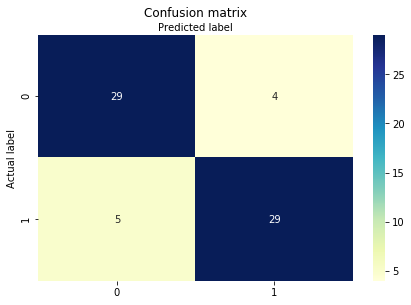

In [24]:
X_season = feature_copy[feature_list]

y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

y_pred_season = svm.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)



In [25]:
prediction_probabilities = svm.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.8656716417910447
Precision: 0.8787878787878788
Recall: 0.8529411764705882
Log loss=  0.42691385418785216


In [ ]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, feature_list, numeric_features, 
                                            prediction_probabilities,X_season,y_season,y_pred_season)

In [ ]:
missed_predictions

In [ ]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

In [ ]:
#Note that the probability of the first team winning is returned in the 2nd column of the prediction_probabilities array

log_loss_result = utils.compute_log_loss(y_season.values, prediction_probabilities[:,1] )
log_loss_result

In [ ]:
prediction_probabilities[:,1]

In [ ]:
y_season.values

In [ ]:
svm.classes_

#### What predictions were counter to seeding?

In [ ]:
y_pred_season

In [ ]:
tourney_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_season.index)].copy()
tourney_games

In [ ]:
tourney_games['predicted'] = y_pred_season
tourney_games.head()

In [ ]:
cond_1 = (tourney_games['seed_t'] > tourney_games['seed_o']) & (tourney_games['predicted'] == 1)
cond_2 = (tourney_games['seed_t'] < tourney_games['seed_o']) & (tourney_games['predicted'] == -1)

predictions_counter_seed = tourney_games[cond_1 | cond_2]
predictions_counter_seed[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

In [ ]:
# correct counter seed predictions
correct_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result']== predictions_counter_seed['predicted']]
correct_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

In [ ]:
# incorrect counter seed predictions
wrong_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result'] != predictions_counter_seed['predicted']]
wrong_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

In [ ]:
print("Number of counter seed predictions= ", len(predictions_counter_seed.index))
print("Number of correct counter seed predictions= ", len(correct_counter_predictions.index))